# Data Processing

Julian Domingo - jad5348

This file contains all transformation / feature engineering techniques used to fit the various base learners fed to my meta learner.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm, probplot
from collections import Counter
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# ignore warnings (i.e. deprecation warnings)
import warnings
warnings.filterwarnings('ignore')

In [31]:
def write_data(file_name, data, is_train):
    if is_train:
        data.to_csv("./data/refined/train/{}".format(file_name), index=False)
    else:
        data.to_csv("./data/refined/test/{}".format(file_name), index=False)

In [32]:
def scatter_plot(data, ids):
    """ Displays a scatter plot of each feature's distribution of values."""
    for feature in data:
        plt.scatter(ids, data[feature])
        plt.title(feature)
        plt.show()

In [33]:
#histogram and normal probability plot
def display_hist_and_prob_plots(columns):
    for feature in columns:
        sns.distplot(x_train[feature], fit=norm);
        plt.title(feature)
        fig = plt.figure()
        res = probplot(x_train[feature], plot = plt)
        plt.show()

In [34]:
def get_train_test_copy(train, test):
    return train.copy(deep = True), test.copy(deep = True)

In [35]:
train = pd.read_csv("data/raw/train.csv", index_col=0)
test = pd.read_csv("data/raw/test.csv", index_col=0)

In [36]:
train.head()

Y     F1     F2  F3  F4      F5    F6      F7  F8      F9 ...   F18  \
id                                                            ...         
1   1  38733  61385   0  38  118751  1000   32020   1  121980 ...     1   
2   1  34248  51329   0  41  120800  1000  130630   1  124029 ...     1   
3   1  15830   5522   0  50  118779  1000  303218   2  122006 ...     1   
4   1  19417   6754   0  45  123163  2000   19024   1  126391 ...     1   
5   1  42122  16991   0  41  119193  1000  303218   1  122422 ...     1   

       F19  F20  F21     F22  F23    F24  F25  F26  F27  
id                                                       
1   118830    1    1  126461    1  46871  NaN  NaN  NaN  
2   118832    1    1  130296    1  42386  NaN  NaN  NaN  
3   118832    1    2  127063    1  23968  NaN  NaN  NaN  
4   118832    1    1   15274    1  27555  NaN  NaN  NaN  
5   118832    1    1  133491    1  50260  NaN  NaN  NaN  

[5 rows x 28 columns]

In [37]:
train.isnull().sum()

Y          0
F1         0
F2         0
F3         0
F4         0
F5         0
F6         0
F7         0
F8         0
F9         0
F10        0
F11        0
F12        0
F13        0
F14        0
F15        0
F16        0
F17        0
F18        0
F19        0
F20        0
F21        0
F22        0
F23        0
F24        0
F25    16383
F26    16383
F27    16383
dtype: int64

Clearly, we can remove **F25**, **F26**, and **F27** from our data set.

In [38]:
drop_columns = ["F25", "F26", "F27"]

# axis = 1 indicates drop from column, 0 would be row
train.drop(drop_columns, axis = 1, inplace = True)

In [39]:
write_data("train_raw.csv", train, is_train=True)
write_data("test_raw.csv", test, is_train=False)

In [40]:
def display_pearson_correlation_matrix(train):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(24,24))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
                square=True, cmap=colormap, linecolor='white', annot=True)
    plt.show()

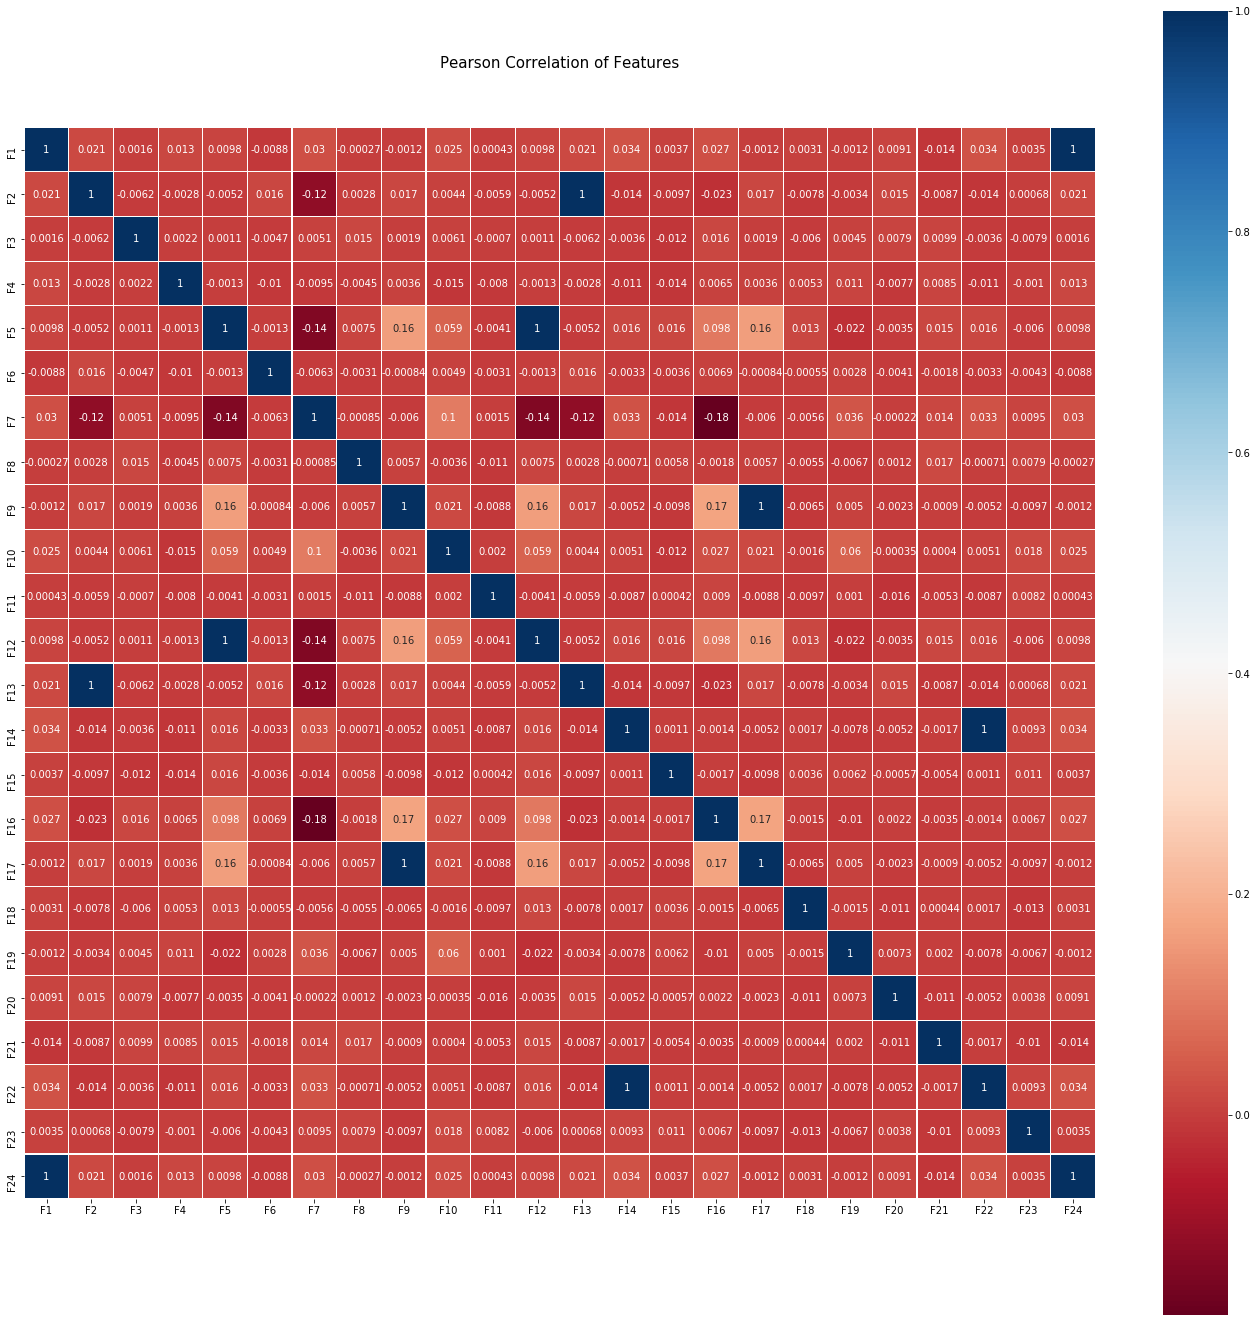

In [41]:
display_pearson_correlation_matrix(train.drop(["Y"], axis = 1))

From viewing the Pearson correlation matrix, it's clear some of the features are linearly depenedent of another feature due to their correlation of precisely 1 (obviously excluding the diagonal); we should remove one of them to reduce unneeded complexity to our data.

Perfect correlation pairs:
1. (~~F1~~, F24)
2. (F2, ~~F13~~)
3. (F5, ~~F12~~)
4. (~~F9~~, F17)
5. (~~F14~~, F22)

Which pair I cull can be reasoned by looking at the "feature_importances" ranking from predictions through a lone RandomForestClassifier using the raw data sets (except removing NaN columns)

In [42]:
# remove repeat features
lin_dependent_features = ["F1", "F9", "F12", "F13", "F14"]

train.drop(lin_dependent_features, axis = 1, inplace = True)
test.drop(lin_dependent_features, axis = 1, inplace = True)

### Transformations

In [43]:
# None (except with feature selection techniques used above); used as baseline data.
write_data("train_base.csv", train, is_train=True)
write_data("test_base.csv", test, is_train=False)

In [44]:
# Log(x + 1) transform
train_log, test_log = get_train_test_copy(train, test)

for feature in train_log:
    if feature != "Y":
        train_log[feature] = np.log(train_log[feature] + 1)

for feature in test_log:
    test_log[feature] = np.log(test_log[feature] + 1)
    
write_data("train_log.csv", train_log, is_train=True)
write_data("test_log.csv", test_log, is_train=False)

In [45]:
train_log.head()

Y         F2   F3        F4         F5        F6         F7        F8  \
id                                                                          
1   1  11.024937  0.0  3.663562  11.684793  6.908755  10.374147  0.693147   
2   1  10.846031  0.0  3.737670  11.701900  6.908755  11.780132  0.693147   
3   1   8.616676  0.0  3.931826  11.685028  6.908755  12.622211  1.098612   
4   1   8.818038  0.0  3.828641  11.721272  7.601402   9.853509  0.693147   
5   1   9.740498  0.0  3.737670  11.688508  6.908755  12.622211  0.693147   

          F10       F11       F15        F16        F17       F18        F19  \
id                                                                             
1   11.759473  0.693147  0.693147  11.693228  11.687727  0.693147  11.685458   
2   11.762462  1.098612  0.693147  11.835813  11.704785  0.693147  11.685474   
3   11.762127  0.693147  0.693147  11.693395  11.687945  0.693147  11.685474   
4   11.759543  0.693147  1.098612  12.508537  11.724094  0.693147  11.685474   
5   11.762127  0.693147  0.693147  11.693395  11.691431  0.693147  11.685474   

         F20       F21        F22       F23        F24  
id                                                      
1   0.693147  0.693147  11.747697  0.693147  10.755176  
2   0.693147  0.693147  11.777572  0.693147  10.654597  
3   0.693147  1.098612  11.752446  0.693147  10.084517  
4   0.693147  0.693147   9.633973  0.693147  10.223976  
5   0.693147  0.693147  11.801797  0.693147  10.824985

In [46]:
test_log.head()

F2        F3        F4         F5        F6         F7  \
id                                                                     
16384  11.815966  0.000000  3.526361  11.700060  9.741027  11.870761   
16385  10.908814  0.000000  3.663562  11.695789  9.798183  12.661971   
16386  10.063819  0.693147  3.332205  11.697478  6.908755  11.870110   
16387  11.430152  0.000000  3.526361  11.685575  7.601402  11.776727   
16388   9.006632  0.000000  3.713572  11.824915  7.601402  11.791103   

             F8        F10       F11       F15        F16        F17  \
id                                                                     
16384  0.693147  11.851838  0.693147  0.693147  11.761105  11.705832   
16385  0.693147  11.835378  0.693147  0.693147  11.708895  11.701594   
16386  0.693147  11.834726  0.693147  0.693147  12.658265  11.703265   
16387  0.693147  11.760496  0.693147  0.693147  11.850433  12.105993   
16388  0.693147  11.760192  0.693147  0.693147  11.708846  11.827459   

            F18        F19       F20       F21        F22       F23        F24  
id                                                                              
16384  0.693147  11.712473  0.693147  0.693147  11.757416  0.693147  10.494879  
16385  0.693147  11.692777  0.693147  1.098612  11.755417  0.693147  11.414022  
16386  0.693147  11.692777  0.693147  0.693147  11.752179  0.693147  10.738330  
16387  0.693147  11.686559  0.693147  0.693147  11.759582  0.693147  11.328269  
16388  0.693147  11.685474  0.693147  0.693147  11.751375  0.693147  11.433687

In [47]:
# StandardScaler transform
train_scaled, test_scaled = get_train_test_copy(train, test)

for feature in train_scaled:
    if feature != "Y":
        train_scaled[feature] = StandardScaler().fit_transform(train_scaled[feature].values.reshape(-1, 1))
    
for feature in test_scaled:
    test_scaled[feature] = StandardScaler().fit_transform(test_scaled[feature].values.reshape(-1, 1))
    
write_data("train_scaled.csv", train_scaled, is_train=True)
write_data("test_scaled.csv", test_scaled, is_train=False)

In [48]:
train_scaled.head()

Y        F2        F3        F4        F5        F6        F7        F8  \
id                                                                            
1   1  0.989123 -0.174001 -0.400691 -0.394364 -0.046879 -1.684821 -0.173416   
2   1  0.707771 -0.174001  0.199448 -0.041259 -0.046879 -0.705864 -0.173416   
3   1 -0.573842 -0.174001  1.999866 -0.389539 -0.046879  1.007515  3.839408   
4   1 -0.539372 -0.174001  0.999634  0.365957 -0.037987 -1.813839 -0.173416   
5   1 -0.252956 -0.174001  0.199448 -0.318194 -0.046879  1.007515 -0.173416   

         F10       F11       F15       F16       F17       F18       F19  \
id                                                                         
1  -0.742600 -0.170802 -0.166718 -0.760193 -0.276906 -0.165442  0.056362   
2  -0.685306  3.444513 -0.166718 -0.495634 -0.211104 -0.165442  0.056544   
3  -0.691738 -0.170802 -0.166718 -0.759905 -0.276071 -0.165442  0.056544   
4  -0.741254 -0.170802  3.470219  1.414747 -0.135251 -0.165442  0.056544   
5  -0.691738 -0.170802 -0.166718 -0.759905 -0.262711 -0.165442  0.056544   

         F20       F21       F22       F23       F24  
id                                                    
1  -0.173744 -0.161232 -0.059196 -0.171408 -0.160254  
2  -0.173744 -0.161232  0.142314 -0.171408 -0.289080  
3  -0.173744  3.564378 -0.027564 -0.171408 -0.818116  
4  -0.173744 -0.161232 -5.901498 -0.171408 -0.715084  
5  -0.173744 -0.161232  0.310194 -0.171408 -0.062909

In [49]:
test_scaled.head()

F2        F3        F4        F5        F6        F7        F8  \
id                                                                            
16384  3.029266 -0.182616 -1.411235 -0.086340 -0.006004 -0.581213 -0.174905   
16385  0.793470 -0.182616 -0.406434 -0.174953 -0.005825  1.132160 -0.174905   
16386 -0.069879  3.871798 -2.616997 -0.139956 -0.008869 -0.582136 -0.174905   
16387  1.829112 -0.182616 -1.411235 -0.385279 -0.008690 -0.708711 -0.174905   
16388 -0.494132 -0.182616 -0.004513  2.678072 -0.008690 -0.689988 -0.174905   

            F10       F11       F15       F16       F17       F18       F19  \
id                                                                            
16384  1.096440 -0.163607 -0.170647 -0.648103 -0.206570 -0.164644  0.358195   
16385  0.761930 -0.163607 -0.170647 -0.741702 -0.223143 -0.164644  0.136576   
16386  0.748789 -0.163607 -0.170647  2.024661 -0.216617 -0.164644  0.136576   
16387 -0.692334 -0.163607 -0.170647 -0.476180  1.721408 -0.164644  0.067511   
16388 -0.698028 -0.163607 -0.170647 -0.741788  0.300172 -0.164644  0.055504   

            F20       F21       F22       F23       F24  
id                                                       
16384 -0.167183 -0.169378  0.015616 -0.165145 -0.490842  
16385 -0.167183  3.829562  0.002118 -0.165145  1.133204  
16386 -0.167183 -0.169378 -0.019691 -0.165145 -0.193818  
16387 -0.167183 -0.169378  0.030279 -0.165145  0.911189  
16388 -0.167183 -0.169378 -0.025091 -0.165145  1.186859

For determining which features to transform, we'll fit a RandomForestClassifier on the baseline data set, then pick the top features which Random Forest deems as most important. 

Running a lone RandomForestClassifier on the base data places highest importance on **F13** and **F24**. We'll appropriately gather features from a polynomial of degree 2, generating $2^{(degree + 1)}$ features.

In [51]:
# Polynomial transform
train_poly, test_poly = get_train_test_copy(train, test)

# Train
features = train_poly[["F2", "F24"]]
pf = PolynomialFeatures(degree = 2, interaction_only = False)

# Don't add the feature of all 1's
poly_features = pf.fit_transform(features)[:,1:]
poly_features = pd.DataFrame(poly_features)

# Shift row index to match train set, rename columns
poly_features.index = np.arange(1, len(poly_features) + 1)
poly_features = poly_features.rename(columns={0: "poly_f2", 1: "poly_f24", 2: "poly_f2*f24", \
                                              3: "poly_f2^2", 4: "poly_f24^2"})
train_poly = pd.concat([train_poly, poly_features], axis=1)

################################################################################################

# Test
features = test_poly[["F2", "F24"]]
pf = PolynomialFeatures(degree = 2, interaction_only = False)

# Don't add the feature of all 1's
poly_features = pf.fit_transform(features)[:,1:]
poly_features = pd.DataFrame(poly_features)

# Shift row index to match test set, rename columns
poly_features.index = np.arange(16384, len(poly_features) + 16384)
poly_features = poly_features.rename(columns={0: "poly_f2", 1: "poly_f24", 2: "poly_f2*f24", \
                                              3: "poly_f2^2", 4: "poly_f24^2"})
test_poly = pd.concat([test_poly, poly_features], axis=1)
    
write_data("train_poly.csv", train_poly, is_train=True)
write_data("test_poly.csv", test_poly, is_train=False)

In [52]:
train_poly.head()

Y     F2  F3  F4      F5    F6      F7  F8     F10  F11      ...       \
id                                                               ...        
1   1  61385   0  38  118751  1000   32020   1  127959    1      ...        
2   1  51329   0  41  120800  1000  130630   1  128342    2      ...        
3   1   5522   0  50  118779  1000  303218   2  128299    1      ...        
4   1   6754   0  45  123163  2000   19024   1  127968    1      ...        
5   1  16991   0  41  119193  1000  303218   1  128299    1      ...        

    F20  F21     F22  F23    F24  poly_f2  poly_f24   poly_f2*f24  \
id                                                                  
1     1    1  126461    1  46871  61385.0   46871.0  3.768118e+09   
2     1    1  130296    1  42386  51329.0   42386.0  2.634666e+09   
3     1    2  127063    1  23968   5522.0   23968.0  3.049248e+07   
4     1    1   15274    1  27555   6754.0   27555.0  4.561652e+07   
5     1    1  133491    1  50260  16991.0   50260.0  2.886941e+08   

       poly_f2^2    poly_f24^2  
id                              
1   2.877176e+09  2.196891e+09  
2   2.175631e+09  1.796573e+09  
3   1.323513e+08  5.744650e+08  
4   1.861065e+08  7.592780e+08  
5   8.539677e+08  2.526068e+09  

[5 rows x 25 columns]

In [53]:
test_poly.head()

F2  F3  F4      F5     F6      F7  F8     F10  F11  F15  \
id                                                                   
16384  135396   0  33  120578  17000  143022   1  140341    1    1   
16385   54655   0  38  120064  18000  315517   1  138050    1    1   
16386   23477   1  27  120267   1000  142929   1  137960    1    1   
16387   92055   0  33  118844   2000  130186   1  128090    1    1   
16388    8156   0  40  136613   2000  132071   1  128051    1    1   

           ...       F20  F21     F22  F23    F24   poly_f2  poly_f24  \
id         ...                                                          
16384      ...         1    1  127696    1  36129  135396.0   36129.0   
16385      ...         1    2  127441    1  90582   54655.0   90582.0   
16386      ...         1    1  127029    1  46088   23477.0   46088.0   
16387      ...         1    1  127973    1  83138   92055.0   83138.0   
16388      ...         1    1  126927    1  92381    8156.0   92381.0   

        poly_f2*f24     poly_f2^2    poly_f24^2  
id                                               
16384  1.833208e+10  4.891722e+09  1.305305e+09  
16385  2.987169e+09  4.950759e+09  8.205099e+09  
16386  5.511695e+08  1.082008e+09  2.124104e+09  
16387  8.474123e+09  7.653269e+09  6.911927e+09  
16388  6.652034e+07  7.534594e+08  8.534249e+09  

[5 rows x 24 columns]

In [72]:
# Reduced
train_reduced, test_reduced = get_train_test_copy(train, test)

When looking at the feature importances in "**layer_1_models.ipynb**", there's a steep dropoff in the importance of **F17** in comparison to **F3**. Thus, we'll describe our "reduced" data set as the top 11 features (after reduced dimensionality).

In [73]:
train_reduced = train_reduced[["Y", "F2", "F24", "F16", "F4", "F22", "F10", "F7", "F19", "F6", "F5", "F17"]]
test_reduced = test_reduced[["F2", "F24", "F16", "F4", "F22", "F10", "F7", "F19", "F6", "F5", "F17"]]

In [74]:
write_data("train_reduced.csv", train_reduced, is_train=True)
write_data("test_reduced.csv", test_reduced, is_train=False)